## Pool Ball Detection and Classification


In [326]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

IMAGE_PATH = "data/pool_table_cropped.png"

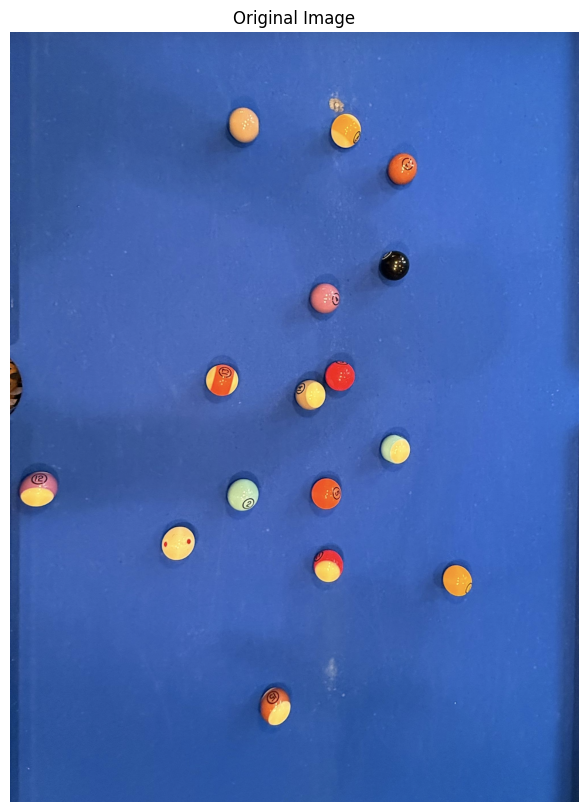

Image loaded: 970x1314 pixels


In [327]:
#Load image
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise ValueError(f"Could not load image from {IMAGE_PATH}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display original image
plt.figure(figsize=(14, 10))
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

print(f"Image loaded: {img.shape[1]}x{img.shape[0]} pixels")

### Convert to HSV Color Space

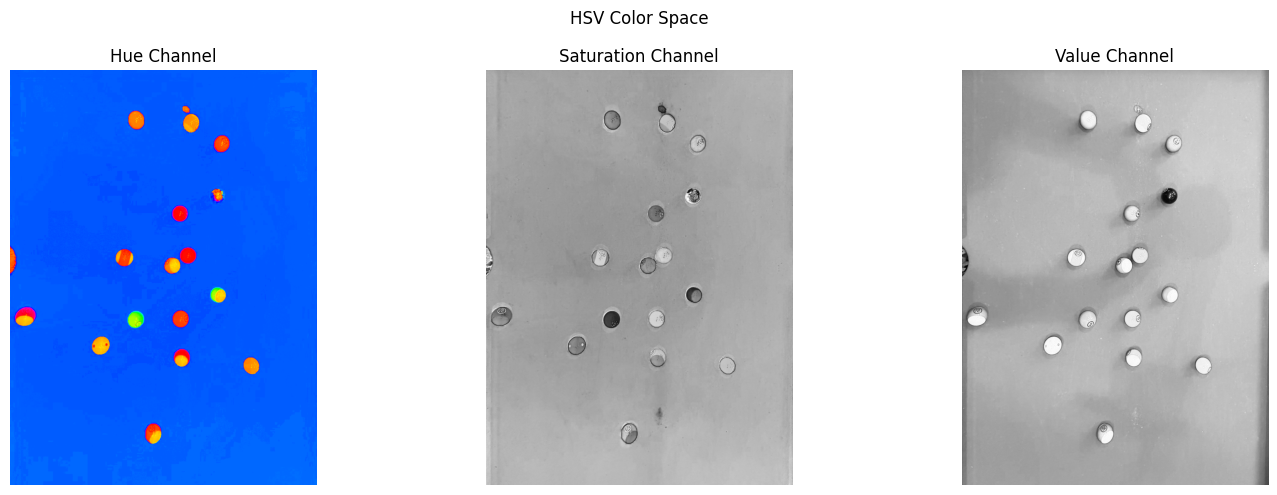

In [328]:
# Convert to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Display HSV channels separately
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(hsv[:, :, 0], cmap='hsv')
axes[0].set_title("Hue Channel")
axes[0].axis('off')

axes[1].imshow(hsv[:, :, 1], cmap='gray')
axes[1].set_title("Saturation Channel")
axes[1].axis('off')

axes[2].imshow(hsv[:, :, 2], cmap='gray')
axes[2].set_title("Value Channel")
axes[2].axis('off')

plt.suptitle("HSV Color Space")
plt.tight_layout()
plt.show()

### Pool Table Detection (Blue Mat Isolation)


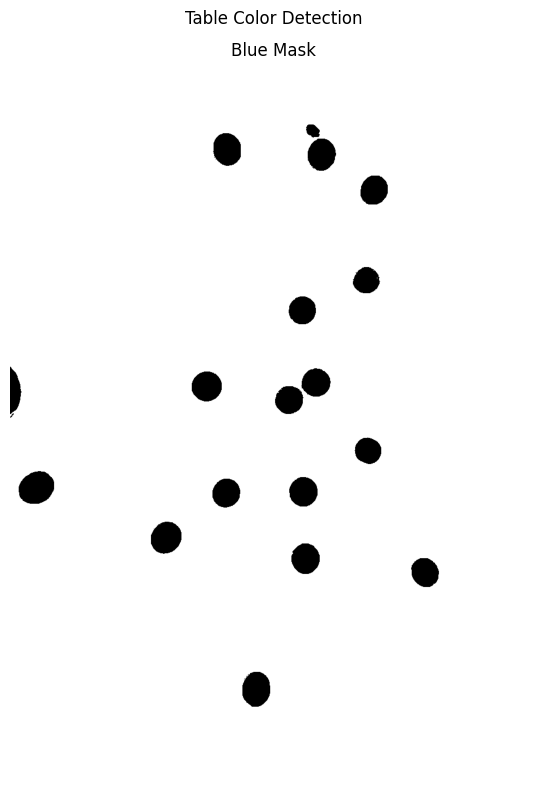

In [329]:
# Blue range
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([130, 255, 255])

# Create masks
table_mask_raw = cv2.inRange(hsv, lower_blue, upper_blue)

# Display individual and combined masks
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.imshow(table_mask_raw, cmap='gray')
axes.set_title("Blue Mask")
axes.axis('off')

plt.suptitle("Table Color Detection")
plt.tight_layout()
plt.show()

## Clean Up Table Mask with Morphological Operations

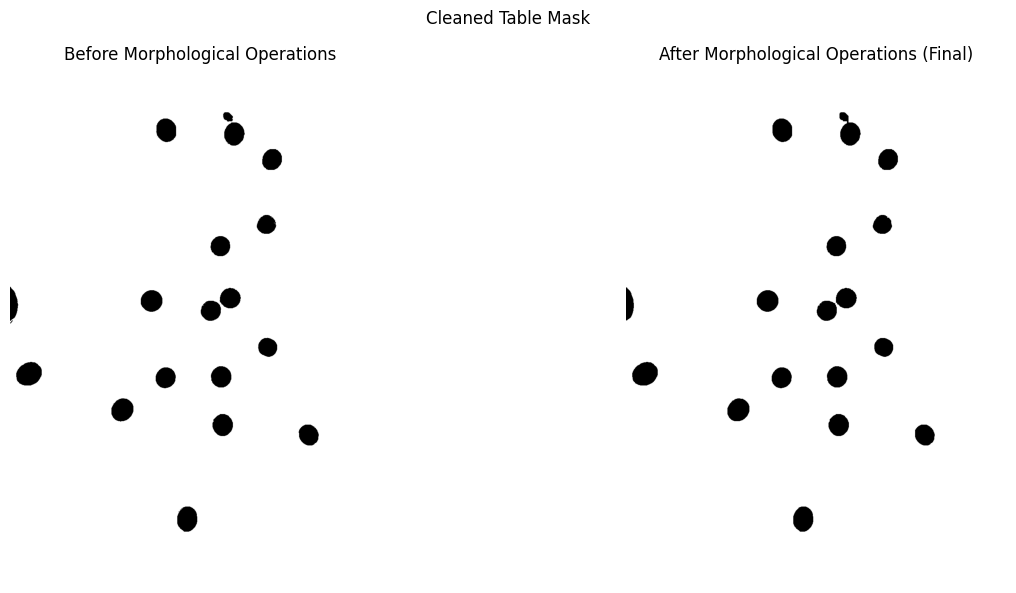

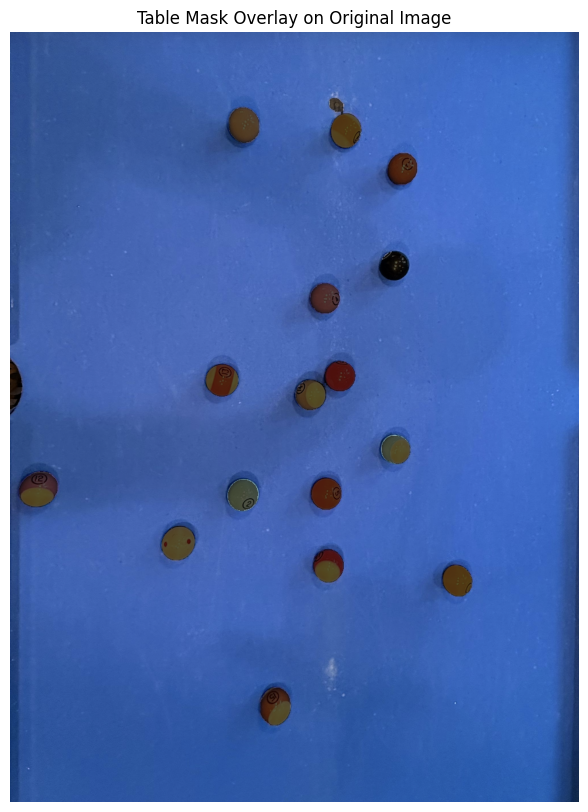

In [330]:
# Apply morphological operations to clean up mask
kernel = np.ones((5, 5), np.uint8)
table_mask = cv2.morphologyEx(table_mask_raw, cv2.MORPH_CLOSE, kernel)
table_mask = cv2.morphologyEx(table_mask, cv2.MORPH_OPEN, kernel)

# Display before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(table_mask_raw, cmap='gray')
axes[0].set_title("Before Morphological Operations")
axes[0].axis('off')

axes[1].imshow(table_mask, cmap='gray')
axes[1].set_title("After Morphological Operations (Final)")
axes[1].axis('off')

plt.suptitle("Cleaned Table Mask")
plt.tight_layout()
plt.show()

# Show mask overlay on original image
masked_img = img_rgb.copy()
masked_img[table_mask == 0] = masked_img[table_mask == 0] // 3

plt.figure(figsize=(14, 10))
plt.imshow(masked_img)
plt.title("Table Mask Overlay on Original Image")
plt.axis('off')
plt.show()

## Ball Detection (Circle Detection)

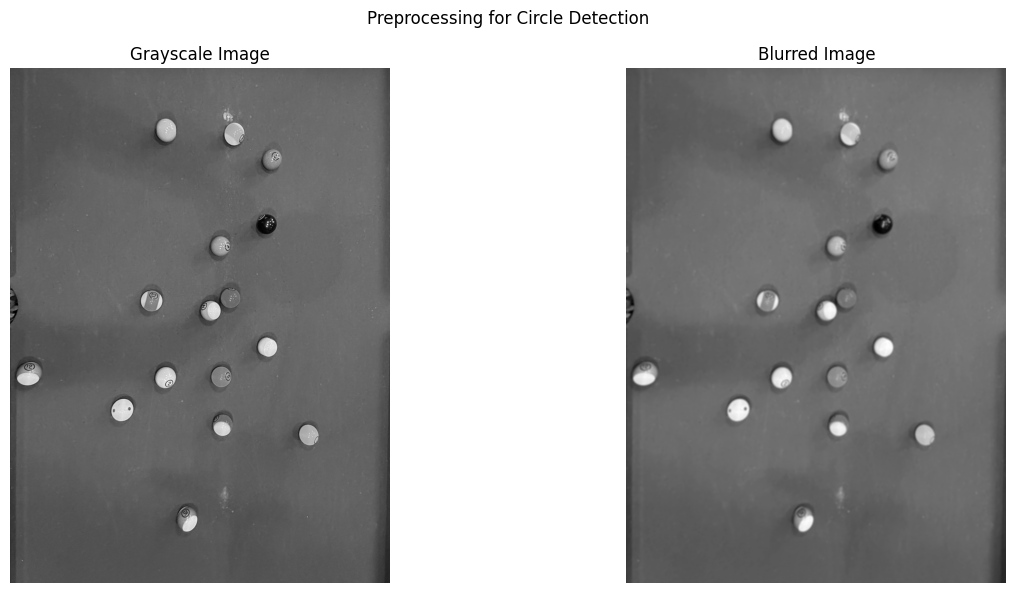

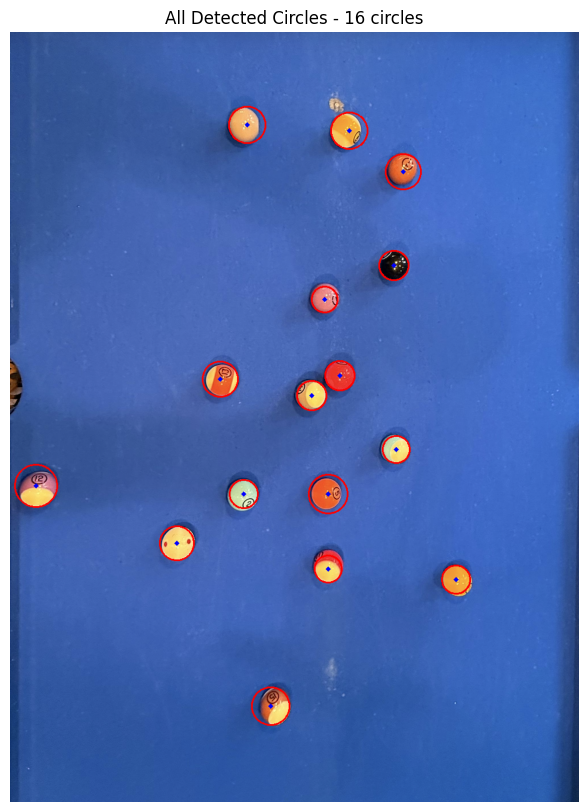

Detected 16 circles before filtering


In [331]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Display grayscale and blurred
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Grayscale Image")
axes[0].axis('off')

axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred Image")
axes[1].axis('off')

plt.suptitle("Preprocessing for Circle Detection")
plt.tight_layout()
plt.show()

# Detect circles using Hough Circle Transform
circles = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=30,
    param1=50,
    param2=30,
    minRadius=10,
    maxRadius=50
)

# Draw all detected circles
if circles is not None:
    circles_uint = np.uint16(np.around(circles))
    img_all_circles = img_rgb.copy()
    
    for circle in circles_uint[0, :]:
        x, y, r = circle
        cv2.circle(img_all_circles, (x, y), r, (255, 0, 0), 2)
        cv2.circle(img_all_circles, (x, y), 2, (0, 0, 255), 3)
    
    plt.figure(figsize=(14, 10))
    plt.imshow(img_all_circles)
    plt.title(f"All Detected Circles - {len(circles_uint[0])} circles")
    plt.axis('off')
    plt.show()
    
    print(f"Detected {len(circles_uint[0])} circles before filtering")
else:
    print("No circles detected!")
    circles_uint = np.array([[]])

## Color Extraction and Analysis

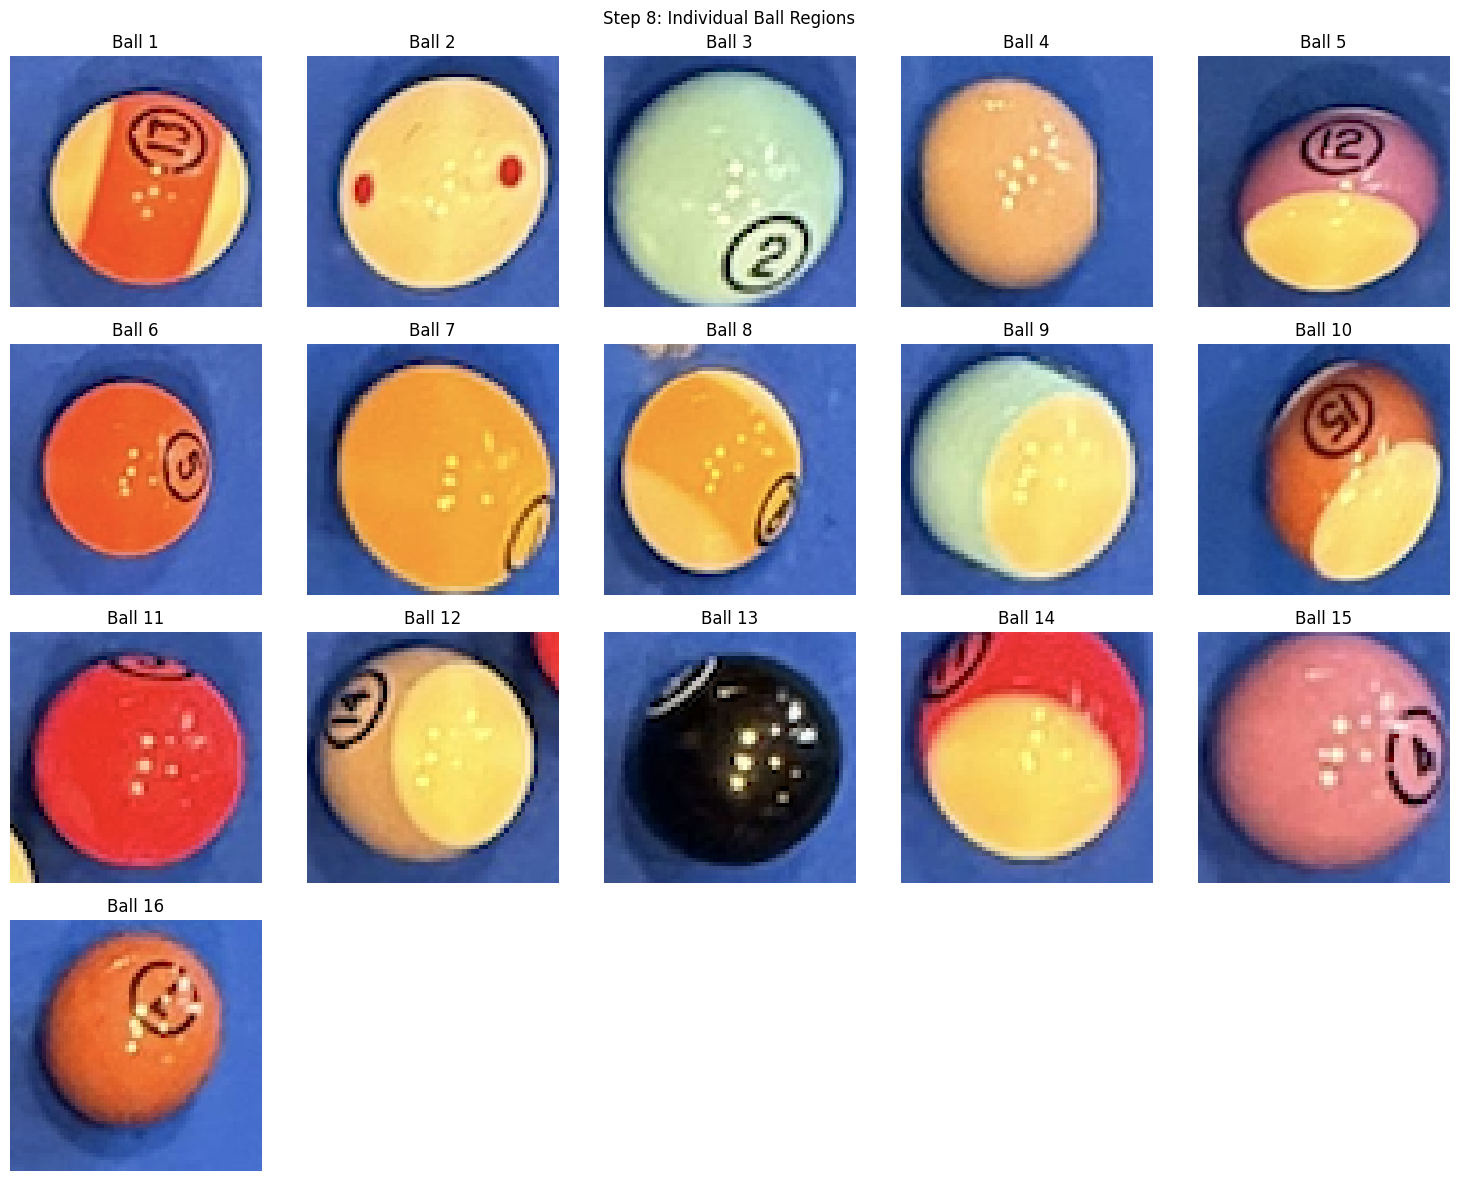

In [332]:
# Show each detected ball region
if circles is not None and len(circles) > 0:
    circles = np.squeeze(circles)
    if circles.ndim == 1 and circles.size == 3:
        circles = circles[np.newaxis, :]
    if circles.ndim != 2 or circles.shape[1] != 3:
        raise ValueError(f"Unexpected circles shape: {circles.shape}")
    circles = np.rint(circles).astype(int)

    n_balls = circles.shape[0]
    cols = min(5, n_balls)
    rows = (n_balls + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes])
    elif cols == 1:
        axes = axes[:, np.newaxis]

    H, W = img_rgb.shape[:2]
    for idx, (x, y, r) in enumerate(circles):
        # Integer & clipped bounds
        y1 = max(0, y - r - 5)
        y2 = min(H, y + r + 5)
        x1 = max(0, x - r - 5)
        x2 = min(W, x + r + 5)

        # Skip if the circle is basically off-image (empty crop)
        if y2 <= y1 or x2 <= x1:
            continue

        ball_region = img_rgb[y1:y2, x1:x2]

        row = idx // cols
        col = idx % cols
        axes[row, col].imshow(ball_region)
        axes[row, col].set_title(f"Ball {idx+1}")
        axes[row, col].axis('off')

    # Hide empty subplots
    for idx in range(n_balls, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')

    plt.suptitle("Step 8: Individual Ball Regions")
    plt.tight_layout()
    plt.show()


In [333]:
def get_dominant_color(img, x, y, r):
    """Extract dominant color from ball region"""
    # Create circular mask for the ball
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x, y), int(r * 0.7), 255, -1)
    
    # Extract pixels
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    pixels = hsv[mask > 0]
    
    if len(pixels) == 0:
        return None, None
    
    # Get median color
    median_hsv = np.median(pixels, axis=0)
    
    return median_hsv, pixels


def is_white_ball(hsv_color):
    """Check if ball is white (cue ball)"""
    h, s, v = hsv_color
    return s < 30 and v > 150


def is_black_ball(hsv_color):
    """Check if ball is black (8-ball)"""
    h, s, v = hsv_color
    return v < 50


def is_striped(pixels, hsv_color):
    """Determine if ball is striped by checking color variance"""
    if len(pixels) == 0:
        return False
    
    # Calculate saturation variance
    saturations = pixels[:, 1]
    sat_std = np.std(saturations)
    
    # Striped balls have higher variance in saturation
    return sat_std > 40


def classify_color(hsv_color):
    """Classify ball color based on HSV values"""
    h, s, v = hsv_color
    
    if is_white_ball(hsv_color):
        return "White (Cue Ball)"
    
    if is_black_ball(hsv_color):
        return "Black (8-Ball)"
    
    # Color classification by hue
    if h < 10 or h > 170:
        return "Red"
    elif 10 <= h < 25:
        return "Orange"
    elif 25 <= h < 35:
        return "Yellow"
    elif 35 <= h < 85:
        return "Green"
    elif 85 <= h < 130:
        return "Blue"
    elif 130 <= h < 150:
        return "Purple"
    elif 150 <= h < 170:
        return "Pink"
    else:
        return "Unknown"

In [334]:
results = []

# Analyze each ball
for idx, (x, y, r) in enumerate(circles):
    # Get color information
    hsv_color, pixels = get_dominant_color(img, x, y, r)
    
    if hsv_color is None:
        continue
    
    # Classify
    color_name = classify_color(hsv_color)
    is_stripe = is_striped(pixels, hsv_color)
    
    ball_type = "Striped" if is_stripe else "Solid"
    
    # Special cases
    if "White" in color_name or "Black" in color_name:
        ball_type = ""
    
    label = f"{color_name} {ball_type}".strip()
    
    results.append({
        'index': idx + 1,
        'position': (x, y),
        'radius': r,
        'color': color_name,
        'type': ball_type,
        'label': label,
        'hsv': hsv_color,
        'sat_std': np.std(pixels[:, 1]) if len(pixels) > 0 else 0
    })
    
    print(f"Ball {idx+1}: {label}")
    print(f"  Position: ({x}, {y})")
    print(f"  HSV: H={hsv_color[0]:.1f}, S={hsv_color[1]:.1f}, V={hsv_color[2]:.1f}")
    print(f"  Saturation StdDev: {np.std(pixels[:, 1]):.1f} (threshold=40)")
    print()

Ball 1: Red Solid
  Position: (358, 592)
  HSV: H=8.0, S=207.0, V=236.0
  Saturation StdDev: 30.6 (threshold=40)

Ball 2: Orange Solid
  Position: (284, 872)
  HSV: H=23.0, S=128.0, V=249.0
  Saturation StdDev: 15.7 (threshold=40)

Ball 3: Green Solid
  Position: (398, 788)
  HSV: H=42.0, S=54.0, V=225.0
  Saturation StdDev: 20.0 (threshold=40)

Ball 4: Orange Solid
  Position: (404, 158)
  HSV: H=16.0, S=132.0, V=243.0
  Saturation StdDev: 22.0 (threshold=40)

Ball 5: Purple Striped
  Position: (44, 774)
  HSV: H=130.0, S=119.0, V=212.0
  Saturation StdDev: 40.2 (threshold=40)

Ball 6: Red Solid
  Position: (542, 788)
  HSV: H=8.0, S=209.0, V=236.0
  Saturation StdDev: 31.9 (threshold=40)

Ball 7: Orange Solid
  Position: (760, 934)
  HSV: H=17.0, S=194.0, V=242.0
  Saturation StdDev: 7.8 (threshold=40)

Ball 8: Orange Solid
  Position: (578, 168)
  HSV: H=18.0, S=192.0, V=242.0
  Saturation StdDev: 32.7 (threshold=40)

Ball 9: Yellow Solid
  Position: (658, 712)
  HSV: H=25.0, S=121.

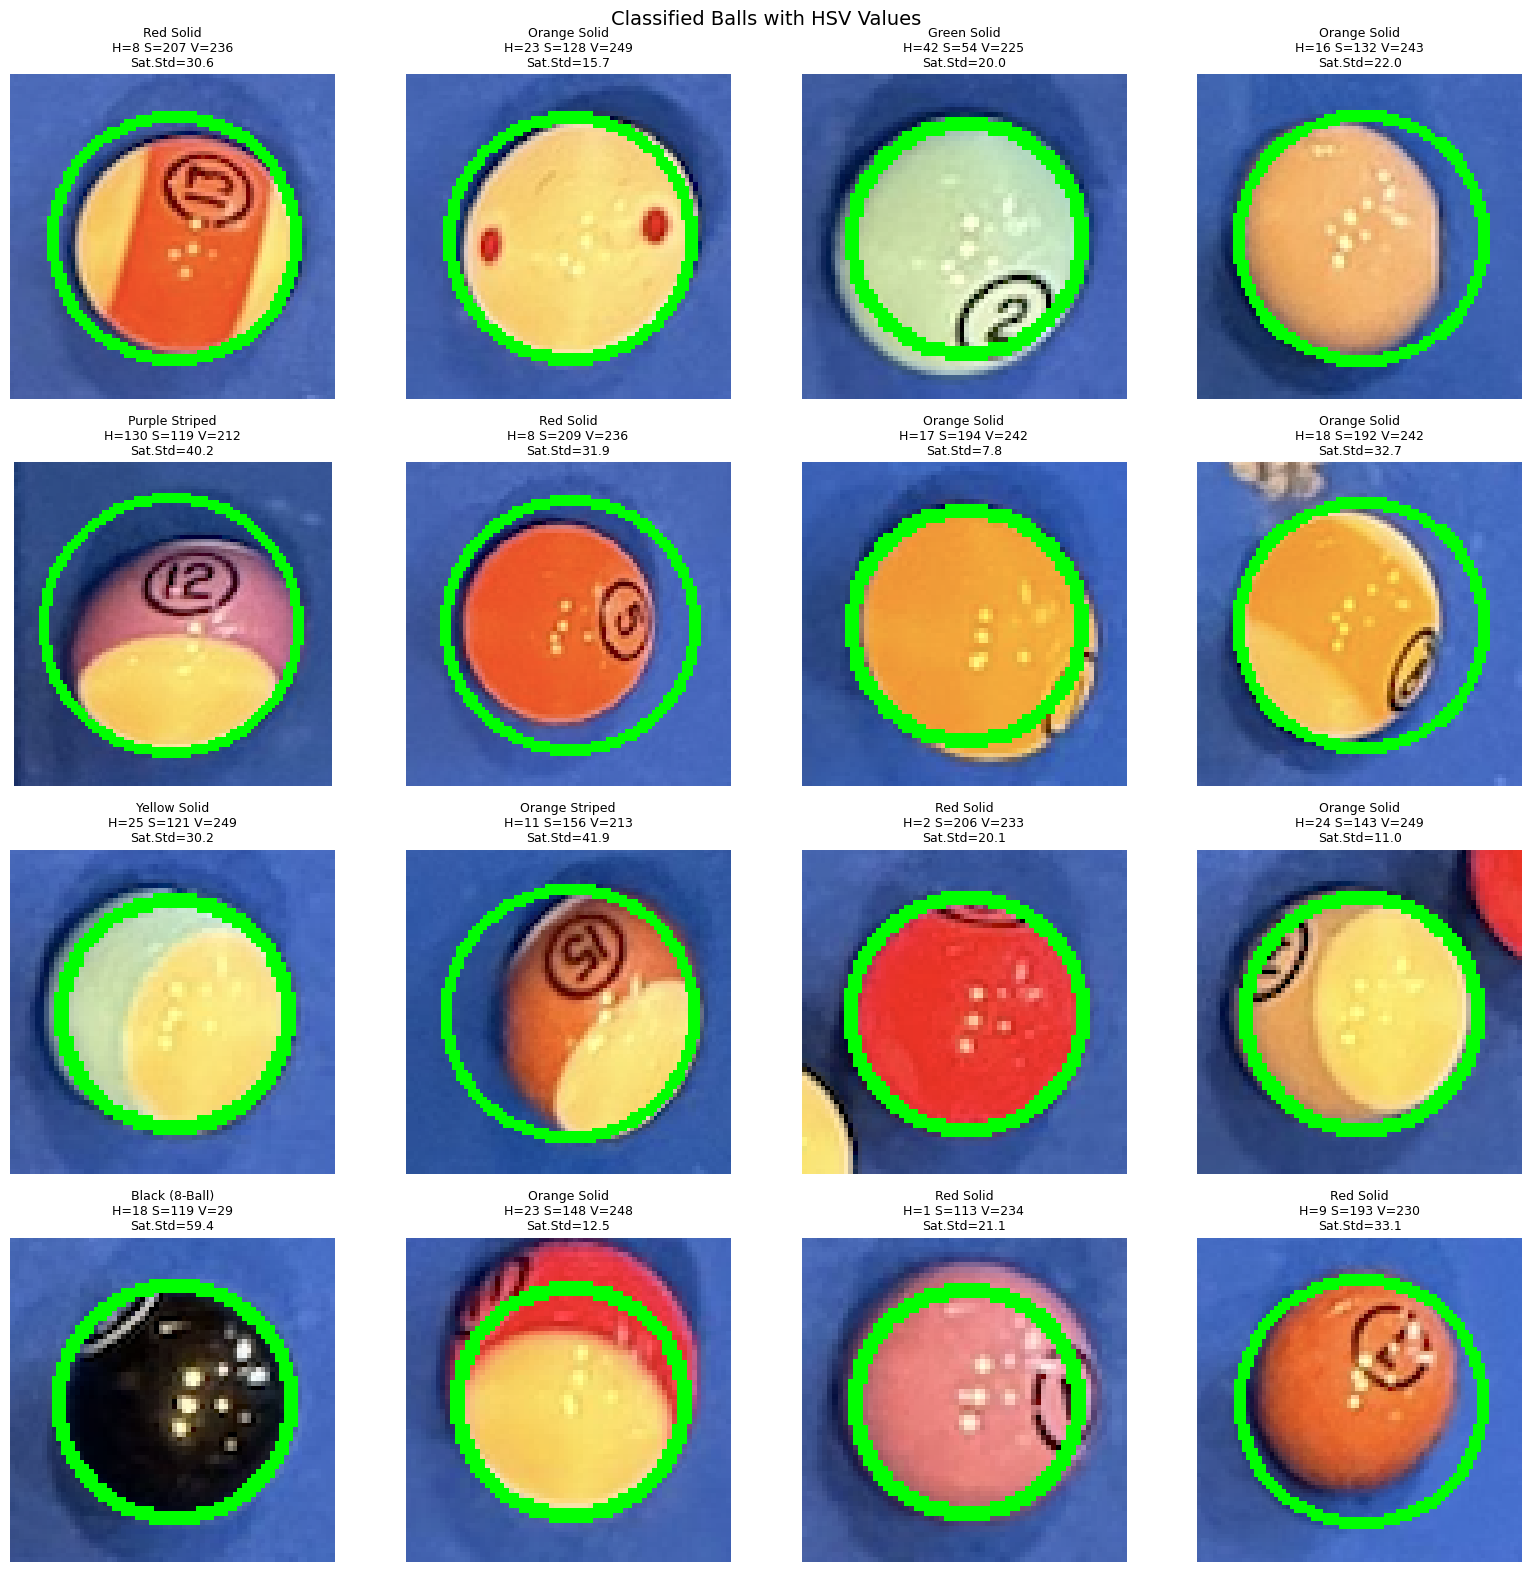

In [335]:
if len(results) > 0:
    n_balls = len(results)
    cols = min(4, n_balls)
    rows = (n_balls + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    for idx, ball in enumerate(results):
        x, y, r = ball['position'][0], ball['position'][1], ball['radius']
        
        # Extract ball region
        y1, y2 = max(0, y-r-10), min(img_rgb.shape[0], y+r+10)
        x1, x2 = max(0, x-r-10), min(img_rgb.shape[1], x+r+10)
        ball_region = img_rgb[y1:y2, x1:x2].copy()
        
        # Skip if region is empty
        if ball_region.size == 0:
            continue
        
        # Ensure the array is contiguous in memory
        ball_region = np.ascontiguousarray(ball_region)
        
        # Draw circle on region - calculate center relative to the cropped region
        cy = y - y1  # y position in the cropped region
        cx = x - x1  # x position in the cropped region
        cv2.circle(ball_region, (int(cx), int(cy)), int(r), (0, 255, 0), 2)
        
        row = idx // cols
        col = idx % cols
        axes[row, col].imshow(ball_region)
        
        title = f"{ball['label']}\n"
        title += f"H={ball['hsv'][0]:.0f} S={ball['hsv'][1]:.0f} V={ball['hsv'][2]:.0f}\n"
        title += f"Sat.Std={ball['sat_std']:.1f}"
        
        axes[row, col].set_title(title, fontsize=9)
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for idx in range(n_balls, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.suptitle("Classified Balls with HSV Values", fontsize=14)
    plt.tight_layout()
    plt.show()


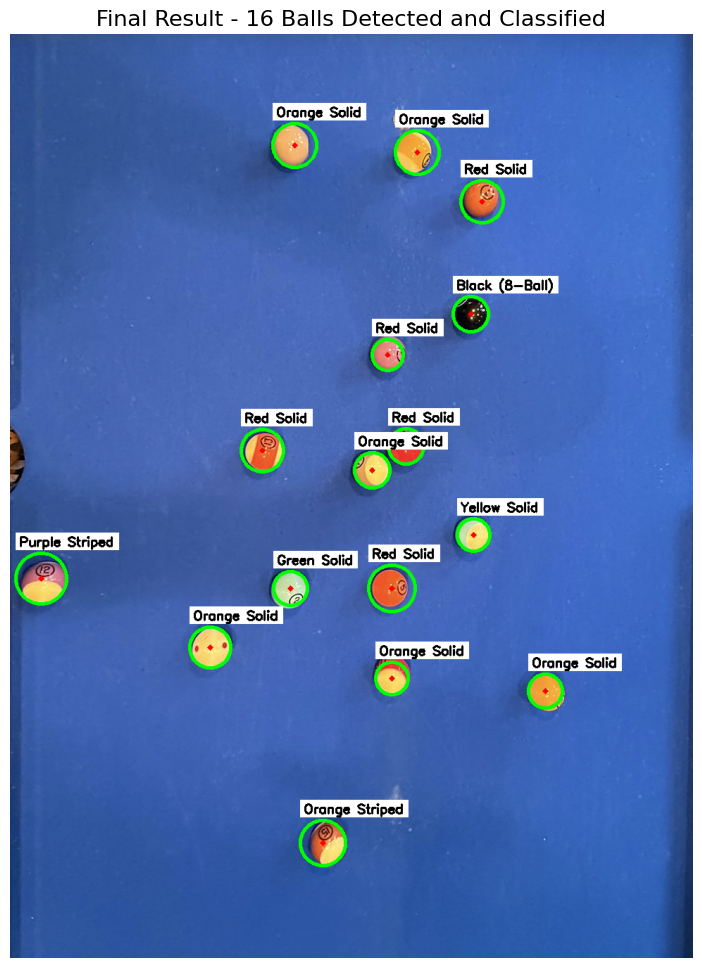

Image saved to: output_images/pool_balls_detected.png


In [336]:
img_final = img_rgb.copy()

for ball in results:
    x, y, r = ball['position'][0], ball['position'][1], ball['radius']
    label = ball['label']
    
    # Draw circle
    cv2.circle(img_final, (x, y), r, (0, 255, 0), 3)
    cv2.circle(img_final, (x, y), 2, (255, 0, 0), 4)
    
    # Add label with background
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    thickness = 2
    
    # Get text size for background
    (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)
    
    # Draw background rectangle
    cv2.rectangle(img_final, 
                  (x - r, y - r - text_height - 15),
                  (x - r + text_width + 10, y - r - 5),
                  (255, 255, 255), -1)
    
    # Draw text
    cv2.putText(img_final, label, (x - r + 5, y - r - 10),
                font, font_scale, (0, 0, 0), thickness)

plt.figure(figsize=(16, 12))
plt.imshow(img_final)
plt.title(f"Final Result - {len(results)} Balls Detected and Classified", fontsize=16)
plt.axis('off')
plt.show()

display_img = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)

output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "pool_balls_detected.png")

cv2.imwrite(output_path, display_img)

print(f"Image saved to: {output_path}")



In [337]:
print("\n" + "="*70)
print("FINAL DETECTION SUMMARY")
print("="*70)

for ball in results:
    print(f"{ball['index']}. {ball['label']:25s} at ({ball['position'][0]:3d}, {ball['position'][1]:3d})")

print("\n" + "="*70)
print("BALLS BY COLOR")
print("="*70)

by_color = defaultdict(list)
for ball in results:
    by_color[ball['color']].append(ball['type'])

for color in sorted(by_color.keys()):
    types = by_color[color]
    if types[0]:
        print(f"{color:20s}: {', '.join(types)}")
    else:
        print(f"{color:20s}: Special ball")

print("\n" + "="*70)
print(f"Total balls detected: {len(results)}")
print("="*70)


FINAL DETECTION SUMMARY
1. Red Solid                 at (358, 592)
2. Orange Solid              at (284, 872)
3. Green Solid               at (398, 788)
4. Orange Solid              at (404, 158)
5. Purple Striped            at ( 44, 774)
6. Red Solid                 at (542, 788)
7. Orange Solid              at (760, 934)
8. Orange Solid              at (578, 168)
9. Yellow Solid              at (658, 712)
10. Orange Striped            at (444, 1150)
11. Red Solid                 at (562, 586)
12. Orange Solid              at (514, 620)
13. Black (8-Ball)            at (654, 398)
14. Orange Solid              at (542, 916)
15. Red Solid                 at (536, 456)
16. Red Solid                 at (670, 238)

BALLS BY COLOR
Black (8-Ball)      : Special ball
Green               : Solid
Orange              : Solid, Solid, Solid, Solid, Striped, Solid, Solid
Purple              : Striped
Red                 : Solid, Solid, Solid, Solid, Solid
Yellow              : Solid

Total balls d